![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [110]:
# Celda 1

#Calculo gini

def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [111]:
#Estimacion gini iputity parar evaluar cada particion

def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [112]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [113]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [138]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=6, num_pct=10)
tree

{'y_pred': 1,
 'y_prob': 0.5778472913408218,
 'level': 0,
 'split': [1, 51394.909090909096],
 'n_samples': 7031,
 'gain': 0.23630504821132137,
 'sl': {'y_pred': 1,
  'y_prob': 0.8375781948168007,
  'level': 1,
  'split': [0, 2015.0],
  'n_samples': 4474,
  'gain': 0.03713896892744761,
  'sl': {'y_pred': 1,
   'y_prob': 0.6404416839199448,
   'level': 2,
   'split': [0, 2013.0],
   'n_samples': 1447,
   'gain': 0.043426293133466354,
   'sl': {'y_pred': 0,
    'y_prob': 0.2780487804878049,
    'level': 3,
    'split': [0, 2012.0],
    'n_samples': 203,
    'gain': 0.05394731382546758,
    'sl': {'y_pred': 0,
     'y_prob': 0.09195402298850575,
     'level': 4,
     'split': [1, 35652.36363636363],
     'n_samples': 85,
     'gain': 0.01352946029496721,
     'sl': {'y_pred': 0,
      'y_prob': 0.24,
      'level': 5,
      'split': [2, 1.0],
      'n_samples': 23,
      'gain': 0.08132745221592097,
      'sl': {'y_pred': 0,
       'y_prob': 0.15,
       'level': 6,
       'split': -1,
   

In [140]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [141]:
prediction = tree_predict(X_test, tree, proba=False)
prediction

array([0., 0., 1., ..., 1., 0., 0.])

In [142]:
accuracy_manual = np.sum(prediction==y_test)/prediction.shape[0]

accuracy_manual




0.8830831408775982

El accuracy obtenido es de 0.8831 con el arbol estimado manualmente.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [118]:
# Celda 2

#Se generan los índices de las muestras aleatorias

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([4390, 1069, 1974, ..., 6622, 3693, 4845]),
 array([3259, 5121, 6516, ..., 4790, 5933, 3270]),
 array([5101, 5526, 4995, ..., 1079, 1870, 5611]),
 array([1978,  796, 5720, ..., 5609, 2625, 1491]),
 array([6305, 6422,  203, ..., 3188, 1699, 6963]),
 array([1846, 3937, 5676, ..., 2573,  301, 1052]),
 array([ 588, 1684, 1192, ..., 2941, 4149, 1348]),
 array([ 802, 3388, 6581, ..., 1779, 4226, 2455]),
 array([5082, 3871, 6339, ..., 2163, 4847, 1097]),
 array([2406, 6488,  578, ..., 5785, 3036, 6680])]

In [144]:

#Se construye un arbol de decision con cada muestra de bootstrap y se almacenan las predicciones


y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])


for i, sample in enumerate(samples):
    X_train_i = X_train.iloc[sample,:]
    y_train_i = y_train.iloc[sample]
    tree_bag = tree_grow(X_train_i, y_train_i, max_depth=6)
    y_pred.iloc[:,i] = tree_predict(X_test, tree_bag)

y_pred.head(10)

,0,1,2,3,4,5,6,7,8,9
257343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
326011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242354,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
266376,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
396954,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
317876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187272,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
372243,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
254404,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [136]:
#Se calcula la prediccion para cada observacion mediante votacion mayoritaria

prediccion_bag = (y_pred.sum(axis=1) >= (n_B / 2)).astype(np.int)

prediccion_bag

257343    0
326011    0
242354    1
266376    1
396954    1
         ..
144298    1
364521    1
120072    1
99878     0
387162    0
Length: 3464, dtype: int32

In [137]:
accuracy_bagging = np.sum(prediccion_bag==y_test)/prediction.shape[0]

accuracy_bagging


0.8859699769053118

El accuracy obtenido es de 0.8859, ligeramente superior (aunque muy similar) al obtenido con un solo arbol (0.8831)

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [12]:
# Celda 3
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

clfBagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, max_features= int(np.log2(X_train.shape[1])), bootstrap=True,
                        random_state=420, n_jobs=-1, oob_score=True)


clfBagging.fit(X_train, y_train)

predicted_clfBag = clfBagging.predict(X_test)

accuracy_bagging_lib = metrics.accuracy_score(y_test, predicted_clfBag)

accuracy_bagging_lib

0.8646073903002309

Al estimar el arbol mediante bagging con el parametro max_features = log2(10), para cada muestra de bootstrap tambien se escogerian aleatoriamente 3 variables explicativas para construir el arbol. Esto genera mas variabilidad. El accuracy estimado es de 0.86 el cual es un poco inferior a los estimados anteriormente.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [7]:
# Celda 4
from sklearn.ensemble import RandomForestClassifier


clfRF = RandomForestClassifier()

clfRF.fit(X_train , y_train)

RandomForestClassifier()

In [206]:
RFpredict = clfRF.predict(X_test)

In [207]:
metrics.accuracy_score(y_test, RFpredict)

0.8455542725173211

El accuracy obtenido con el modelo de Random Forest es 0.845, inferior a los estimados anteriormente.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

Para la calibracion se analizara cada parametro individualmente y finalmente se realizara un gridsearch para hayar el optimo.

In [9]:
# Celda 5
from sklearn.model_selection import cross_val_score

#Calibracion max_depth

max_depths = np.arange(1,30,1)

accuracy_max_depth = []

for md in max_depths:

    clfRF_md = RandomForestClassifier(max_depth=md)
    accuracy_max_depth.append(cross_val_score(clfRF_md, X_train, y_train).mean())



Text(0, 0.5, 'Accuracy')

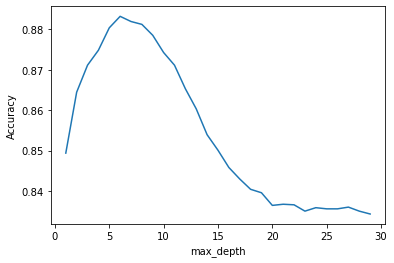

In [10]:
import matplotlib.pyplot as plt
plt.plot(max_depths, accuracy_max_depth)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

Se encuentra que el accuracy aumenta en la medida que aumenta el max_depth a valores 6-7 y posteriormente empiza a disminuir (ya que probablemente se genera overfitting)

In [210]:
max_features_r = np.arange(1,X_train.shape[1],1)

accuracy_max_features = []

for mf in max_features_r:

    clfRF_mf = RandomForestClassifier(max_features=mf)
    accuracy_max_features.append(cross_val_score(clfRF_mf, X_train, y_train).mean())


Text(0, 0.5, 'Accuracy')

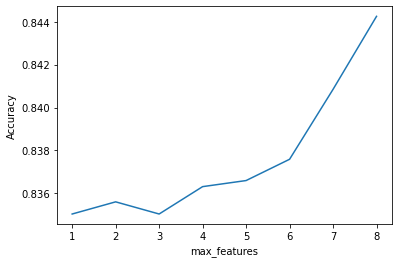

In [211]:
import matplotlib.pyplot as plt
plt.plot(max_features_r, accuracy_max_features)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

Para el caso de los max_features se genera un mejor resultado cuando se consideran todas las variables explicativas en cada particion

In [23]:
n_estimators_r = np.arange(1,300,10)

accuracy_n_estimators = []
roc_auc = []

for n_est in n_estimators_r:

    clfRF_ne = RandomForestClassifier(n_estimators=n_est)
    accuracy_n_estimators.append(cross_val_score(clfRF_ne, X_train, y_train).mean())
    clfRF_ne.fit(X_train,y_train)
    prediccionRFprob = clfRF_ne.predict_proba(X_test)[:,1]
    roc_auc.append(metrics.roc_auc_score(y_test, prediccionRFprob))

Text(0, 0.5, 'Accuracy')

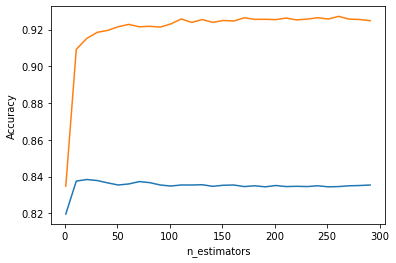

In [24]:
import matplotlib.pyplot as plt
plt.plot(n_estimators_r, accuracy_n_estimators)
plt.plot(n_estimators_r, roc_auc)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

El numero de estimadores calculados en el Random Forest es mayor cuando es un poco menor a 20. A partir de 20el accuracy tiene a ser mas estable, aunque con una ligera tendencia negativa.

In [106]:
# NO CORRER - Se demora mucho - gridsearch con todos los parametros

from sklearn.model_selection import GridSearchCV

clfRF=RandomForestClassifier()
parameters = {'max_depth':max_depths , 'max_features': max_features_r, 'n_estimators': n_estimators_r}


RF_calib = GridSearchCV(clfRF,parameters, n_jobs=-1)
RF_calib.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'max_features': array([1, 2, 3, 4, 5, 6, 7, 8]),
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [107]:
RF_calib.best_params_

{'max_depth': 7, 'max_features': 2, 'n_estimators': 96}

In [222]:
#Se estima el modelo con los parametros optimos hallados con el gridsearch.

clfRF_calib= RandomForestClassifier(max_depth=7, max_features=2, n_estimators=96)
clfRF_calib.fit(X_train,y_train)
predict_RF=clfRF_calib.predict(X_test)

accuracy_RF_calib = metrics.accuracy_score(y_test, predict_RF)
accuracy_RF_calib

0.8859699769053118

Se obtiene que el mejor modelo se obtiene con los siguientes parametros 'max_depth': 7, 'max_features': 2, 'n_estimators': 96. El accuracy obtenido es de 0.886 vs el obtenido anteriormente de 0.84 con el modelo sin calibrar.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [57]:
# Celda 6
from xgboost import XGBClassifier
clfXGB = XGBClassifier()
clfXGB.fit(X_train, y_train)

predictXGB = clfXGB.predict(X_test)

metrics.accuracy_score(y_test, predictXGB)

[19:35:52] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8856812933025404

In [58]:
clfXGB.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>

Sin calibrar los hiperparametros del XGBoost se obtiene un accuracy de 0.8856, parecido al obtenido con el Random Forest despues de calibrado.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [59]:
#NO CORRER - Se demora mucho. - Se realiza Gridsearch para buscar los parametros optimos.

# Celda 7
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

#Learning rate

learning_rate_range = np.arange(0.0,1,0.1)
gamma_r = np.arange(0,10.2,0.2)
colsample_bytree_r = np.arange(0.1, 1 , 0.2)


clfXGB2=XGBClassifier()
parameters = {'eta':learning_rate_range , 'gamma': gamma_r, 'colsample_bytree': colsample_bytree_r}
XGB_calib = GridSearchCV(clfXGB2,parameters, n_jobs=-1)
XGB_calib.fit(X_train,y_train)

[20:47:53] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_est...
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'colsample_bytree': array([0.1, 0.3, 0.5, 0.7, 0.9]),
                         'eta': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7

In [60]:
predictXGBcalib = XGB_calib.predict(X_test)

metrics.accuracy_score(y_test, predictXGBcalib)


0.8891454965357968

In [61]:
params = XGB_calib.best_params_

params['objective'] = 'binary:logistic'
params

{'colsample_bytree': 0.5000000000000001,
 'eta': 0.30000000000000004,
 'gamma': 8.6,
 'objective': 'binary:logistic'}

Se encuentra que los mejores parametros son considerar 50% de las variables explicativas en cada arbol, learning rate de 0.3, y un gamma (disminucion minima en la perdidad para hacer una particion) del 8.6

In [218]:
#Se estima el modelo con los parametros optimos

clfXGB = XGBClassifier( **params )
clfXGB.fit(X_train, y_train)

predictXGB = clfXGB.predict(X_test)

accuracy_xgb_calib = metrics.accuracy_score(y_test, predictXGB)

accuracy_xgb_calib

[23:38:56] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8891454965357968

El accuracy estimado es un poco superior al encontrado con el modelo XGBoost sin calibrar.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

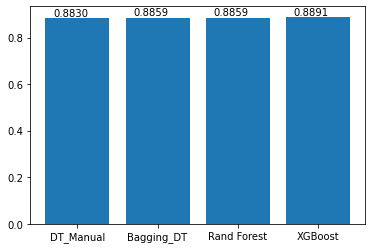

In [250]:
# Celda 8

modelos = ['DT_Manual' , 'Bagging_DT', 'Rand Forest', 'XGBoost' ]
valores = [accuracy_manual, accuracy_bagging, accuracy_RF_calib, accuracy_xgb_calib ]
xpos = np.arange(len(valores))

plt.bar(modelos, valores)

for i, v in enumerate(valores):
    plt.text( x= xpos[i]-0.3, y=v, s = str(v)[0:6], verticalalignment='bottom')

Los diferentes modelos tienen un desempeño muy parecido cuando comparamos el accuracy. El XGBoost tiene un Accuracy mayor de 0.8891 vs el arbol de decision manual, que tiene un accuracy de 0.8830. Si se tiene en cuenta que la ganancia de modelo de arbol de decision comparado con XGBoost es marginal, seria mejor escoger el modelo de arbol de decision por su facilidad de interpretacion.



Al comparar los diferentes modelo se encuentra que XGBoost es un modelo versatil ya que incluye varias mejoras como el tree prunning, imputacion de datos faltantes y cross validation, esto hace que el algoritmo tenga un buen desempeno incluso antes de calibrar, sin embargo se pierde la interpretabilidad. XGBoost es un modelo de Boosting, en el sentido que se realizan arboles de decision de manera secuencial, en la que cada arbol aprende de los errores de los arboles anteriores. 
Por el contrario, Random Forest genera arboles de manera paralela y al final se toma la votacion de los diferentes arboles. Aunque Random Forest no hace imputacion de valores faltantes, este algoritmo no se ve muy afectado por la existencia de los mismos. Random Forest genera variabilidad mediante bootstrap y mediante seleccion de variables explicativas de manera aleatoria para la construccion de cada arbol, lo que permite mejorar las predicciones.